In [1]:
#GPU enable
import os
import tensorflow as tf
 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
#필요 module 설치
!pip install -r breed_requirements.txt
#!pip install tf_explain
#!pip install --upgrade pandas
#!pip install opencv-python
#!pip install matplotlib
#!pip install pillow
#!pip install sklearn
#!pip install keras==2.6.0
#!pip install imgaug

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 31.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 21.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 32.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 KB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.8/500.8 KB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 KB 23.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━

In [3]:
#필요 library import
import os
import pandas as pd

import xml.etree.ElementTree as ET
#import gdown
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

from keras.utils import np_utils
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.activations import ExtractActivations

from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report

from PIL import Image
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
print("Loaded all libraries")

Loaded all libraries


In [4]:
#변수 지정
image_path = './input/Images'
output_num = 3
num_of_categories = 3
image_size = 299
#epoch은 계산해서 바꾸기

In [4]:
#이미지파일 압축 해제(최초 1회만 진행)
import tarfile
ap=tarfile.open('./images_crop_1.tar')
ap.extractall('./input')
ap.close()

In [7]:
#annotation파일 압축 해제(최초 1회만 진행)
ap=tarfile.open('./annotation_crop_1.tar')
ap.extractall('./input')
ap.close()

In [5]:
#image 경로를 통한 종 list 지정
breed_list = sorted(os.listdir(image_path))

num_classes = len(breed_list)
print("{} breeds".format(num_classes))
print(breed_list)

3 breeds
['Maltese', 'Pomeranian_long', 'Pomeranian_short']


In [6]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [7]:
# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
    print(breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

FileExistsError: [Errno 17] File exists: 'data'

In [11]:
%%time
# 'data' 폴더에 crop(bound box 크기로 crop)된 image들을 넣음 - training에 사용
for breed in os.listdir('data'):
    for file in os.listdir('./input/Annotation/{}'.format(breed)):
        img = Image.open('./input/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('./input/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((image_size, image_size))
        img.save('data/' + breed + '/' + file + '.jpg')

CPU times: user 3.73 s, sys: 327 ms, total: 4.06 s
Wall time: 5.86 s


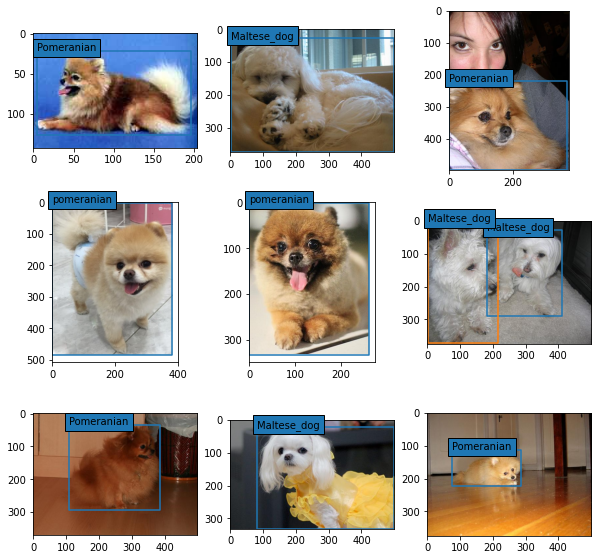

In [12]:
# random으로 사진 출력(bound box 포함)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(331 + i) # showing 9 random images
    breed = np.random.choice(breed_list) # random breed
    dog = np.random.choice(os.listdir('./input/Annotation/' + breed)) # random image 
    img = Image.open('./input/Images/' + breed + '/' + dog + '.jpg') 
    tree = ET.parse('./input/Annotation/' + breed + '/' + dog) # init parser for file given
    root = tree.getroot() # idk what's it but it's from documentation
    objects = root.findall('object') # finding all dogs. An array
    plt.imshow(img) # displays photo
    for o in objects:
        bndbox = o.find('bndbox') # reading border coordinates
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # showing border
        plt.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) # printing breed

In [13]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [14]:
#path:종이름+image 이름, target:라벨링(Y)
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = np_utils.to_categorical(targets, num_classes=num_classes)

In [15]:
#Image Generator class - 이미지 augmentation
class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    # data augmentation
    def __load_image(self, path):
        image = cv2.imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),  # horizontally flip 50% of the images
                    iaa.Flipud(0.5),  # vertically flip 50% of the images
                    iaa.Sometimes(0.5,  # applies the given augmenter in 50% of all cases
                    
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-40, 40),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [16]:
# data split(train, validation, test), image augmentation
x_train, x_test, y_train, y_test = train_test_split(paths, targets, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

train_ds = ImageGenerator(x_train, y_train, batch_size=32, shape=(image_size, image_size,3), augment=True)
val_ds = ImageGenerator(x_val, y_val, batch_size=32, shape=(image_size, image_size,3), augment=False)
test_ds = ImageGenerator(x_test, y_test, batch_size=32, shape=(image_size, image_size,3), augment=False)

In [17]:
print(len(train_ds))
print(len(val_ds))

15
2


In [18]:
# Xception model 
base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg', input_shape=(299,299,3))#Summary of Xception Model

base_model.trainable = False


#pre_trained_model.summary()

2022-10-12 15:04:16.773285: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 15:04:17.408623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23676 MB memory:  -> device: 0, name: Tesla P40, pci bus id: 0000:06:00.0, compute capability: 6.1


83697664/83683744 [==============================] - 2s 0us/step


In [19]:
# model 생성 (base model +)
flat_dim = 5 * 5 * 2048

my_model = Sequential(base_model)

#my_model.add(Flatten())
#my_model.add(Dropout(0.1)) # dropout added
# 뉴런의 입출력 연결해주는 dense layer
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dense(512, activation='relu'))
#my_model.add(Dropout(0.1))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dense(output_num, activation='softmax'))

[1e-05, 6.505114555849587e-06, 1.3998974074878144e-05, 2.1158257692363077e-05, 2.6349806140466085e-05, 2.9032781503571898e-05, 2.9396559030789573e-05, 2.7979491786027585e-05, 2.540182222438155e-05, 2.2217993076484613e-05, 1.885603456913674e-05, 1.5609303737669377e-05, 1.265427690063973e-05, 1.0077640616334645e-05, 7.903437440340427e-06, 6.116030942221757e-06, 4.677609611772819e-06, 3.5404805065519026e-06, 2.655051675737932e-06, 1.9745568653868732e-06, 1.457488127964179e-06, 1.068520029068309e-06, 7.785125464502897e-07, 5.640054703120814e-07, 4.0647805168961314e-07]


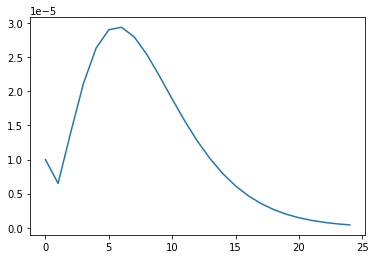

In [20]:
# LearningRateScheduler: epoch이 증가할 수록 lr을 줄여 epoch에 따라 학습률 조정하는 callback
###################
#total_epoch = 100
learning_rate_init = 0.00001
#default: learning_rate_init = 0.00001
###################

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 100:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(100-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [21]:
scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
#early_stop = EarlyStopping(monitor='val_accuracy', patience = 6, mode='max', min_delta=1, verbose=1)

In [22]:
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
process_time_starts()

hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=15, validation_data=val_ds,  validation_steps=2, epochs=50, callbacks=[scheduler])

/home/user/.local/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-10-12 15:04:29.902855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.


2022-10-12 15:04:32.816422: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


15/15 [==============================] - 8s 261ms/step - loss: 1.0464 - accuracy: 0.5769 - val_loss: 0.9701 - val_accuracy: 0.8462
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 6.505114555849587e-06.
15/15 [==============================] - 3s 187ms/step - loss: 0.9581 - accuracy: 0.8205 - val_loss: 0.8948 - val_accuracy: 0.9231
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 1.3998974074878144e-05.
15/15 [==============================] - 3s 187ms/step - loss: 0.8601 - accuracy: 0.8846 - val_loss: 0.7443 - val_accuracy: 0.9615
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 2.1158257692363077e-05.
15/15 [==============================] - 3s 175ms/step - loss: 0.7108 - accuracy: 0.8932 - val_loss: 0.5635 - val_accuracy: 0.9808
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 2.6349806140466085e-05.
15/15 [==============================] - 3s 175ms/step - loss: 0.5381 - accuracy: 0.9295 - va

15/15 [==============================] - 3s 165ms/step - loss: 0.1127 - accuracy: 0.9679 - val_loss: 0.0911 - val_accuracy: 0.9808
Epoch 38/50

Epoch 00038: LearningRateScheduler setting learning rate to 4.110977927300654e-09.
15/15 [==============================] - 3s 185ms/step - loss: 0.1144 - accuracy: 0.9786 - val_loss: 0.0911 - val_accuracy: 0.9808
Epoch 39/50

Epoch 00039: LearningRateScheduler setting learning rate to 2.833711674049488e-09.
15/15 [==============================] - 3s 191ms/step - loss: 0.1333 - accuracy: 0.9594 - val_loss: 0.0911 - val_accuracy: 0.9808
Epoch 40/50

Epoch 00040: LearningRateScheduler setting learning rate to 1.9494374073232167e-09.
15/15 [==============================] - 3s 184ms/step - loss: 0.1093 - accuracy: 0.9615 - val_loss: 0.0911 - val_accuracy: 0.9808
Epoch 41/50

Epoch 00041: LearningRateScheduler setting learning rate to 1.3385924609866778e-09.
15/15 [==============================] - 3s 187ms/step - loss: 0.1263 - accuracy: 0.9679 -

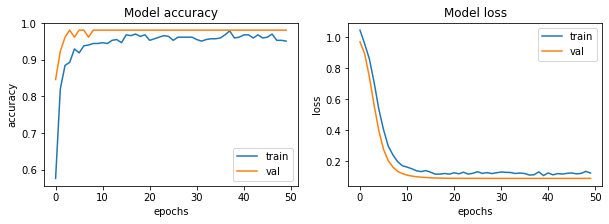

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
my_model.save('my_model.h5', overwrite=True) 
my_model.save_weights('dog_breedClassification3.h5', overwrite=True)
print("Saved model to disk")

/home/user/.local/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [26]:
# test dataset으로 model test
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

/home/user/.local/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test results 
 Loss: 0.10760220885276794 
 Accuracy 0.9692307710647583


In [27]:
# 추가 test를 위한 함수 생성(실제로 결과를 볼 수 있도록)
def download_and_predict(filename):
    # download and save
    #os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((299, 299))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

77.32% 	 Pomeranian_long
21.78% 	 Pomeranian_short
0.90% 	 Maltese


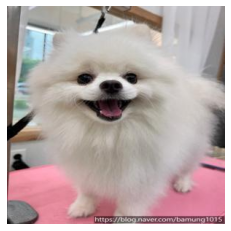

In [29]:
download_and_predict("./test/pome_long_1.jpg")

In [ ]:
download_and_predict("https://img.animalplanet.co.kr/news/2020/06/03/700/oh0m1i1id397rk523z3k.jpg", "test_3.jpg")

75.23% 	 Pomeranian_short
17.15% 	 Maltese
7.62% 	 Pomeranian_long


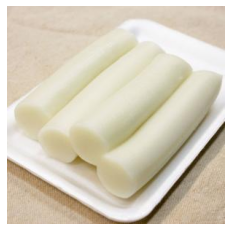

In [52]:
download_and_predict("./test/deock.jpg")

In [84]:
import tensorflow as tf
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path("dog_breedClassification3.tflite")
tflite_model_file.write_bytes(tflite_model)

2022-09-26 16:17:17.709284: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpfnll2i_h/assets


/home/user/.local/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-09-26 16:17:30.468388: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-09-26 16:17:30.468643: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-09-26 16:17:30.480842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 23676 MB memory:  -> device: 0, name: Tesla P40, pci bus id: 0000:04:00.0, compute capability: 6.1
2022-09-26 16:17:30.499921: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.006ms.
  fun

94280532